# Project: Facial Keypoint Detection

---

In this project, I've combined my knowledge of computer vision techniques and deep learning to build and end-to-end facial keypoint recognition system. Facial keypoints include points around the eyes, nose, and mouth on any face and are used in many applications, from facial tracking to emotion recognition. 

There are three main parts to this project:

**Part 1** : Investigating OpenCV, pre-processing, and face detection

**Part 2** : Training a Convolutional Neural Network (CNN) to detect facial keypoints

**Part 3** : Putting parts 1 and 2 together to identify facial keypoints on any image

---

## Steps to Complete the Project

The project itself is broken down into three large parts, then even further into separate steps. The below sections may contain multiple TODOs. For convenience, links are provided to each of these steps below.

**Part 1** : Investigating OpenCV, pre-processing, and face detection

* [Step 0](#step0): Detect Faces Using a Haar Cascade Classifier
* [Step 1](#step1): Add Eye Detection
* [Step 2](#step2): De-noise an Image for Better Face Detection
* [Step 3](#step3): Blur an Image and Perform Edge Detection
* [Step 4](#step4): Automatically Hide the Identity of an Individual

**Part 2** : Training a Convolutional Neural Network (CNN) to detect facial keypoints

* [Step 5](#step5): Create a CNN to Recognize Facial Keypoints
* [Step 6](#step6): Compile and Train the Model
* [Step 7](#step7): Visualize the Loss and Answer Questions

**Part 3** : Putting parts 1 and 2 together to identify facial keypoints on any image

* [Step 8](#step7): Build a Robust Facial Keypoints Detector (Complete the CV Pipeline)



---
<a id='step0'></a>
## Step 0: Detect Faces Using a Haar Cascade Classifier

At its root face detection is a classification problem - that is, a problem of distinguishing between distinct classes of things.  With face detection these distinct classes are 1) images of human faces and 2) everything else. 

I've used OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  I have downloaded one of these detectors and stored it in the `detector_architectures` directory.


### Import Resources 

In the next python cell, we load in the required libraries for this section of the project.

In [1]:
# Import required libraries for this section

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import math
import cv2                     # OpenCV library for computer vision
from PIL import Image
import time 

Next, we load in and display a test image for performing face detection.

*Note*: by default OpenCV assumes the ordering of our image's color channels are Blue, then Green, then Red.  This is slightly out of order with most image types we'll use in these experiments, whose color channels are ordered Red, then Green, then Blue.  In order to switch the Blue and Red channels of our test image around we will use OpenCV's ```cvtColor``` function, which you can read more about by [checking out some of its documentation located here](http://docs.opencv.org/3.2.0/df/d9d/tutorial_py_colorspaces.html).  This is a general utility function that can do other transformations too like converting a color image to grayscale, and transforming a standard color image to HSV color space.

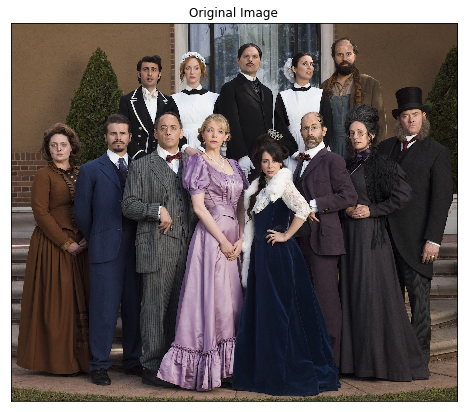

In [2]:
# Load in color image for face detection
image = cv2.imread('images/test_image_1.jpg')

# Convert the image to RGB colorspace
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Plot our image using subplots to specify a size and title
fig = plt.figure(figsize = (8,8))
ax1 = fig.add_subplot(111)
ax1.set_xticks([])
ax1.set_yticks([])

ax1.set_title('Original Image')
ax1.imshow(image)

There are a lot of people - and faces - in this picture.  13 faces to be exact.  In the next code cell, I've demonstrated how to use a Haar Cascade classifier to detect all the faces in this test image.

This face detector uses information about patterns of intensity in an image to reliably detect faces under varying light conditions. So, to use this face detector, we'll first convert the image from color to grayscale. 

Then, we load in the fully trained architecture of the face detector -- found in the file *haarcascade_frontalface_default.xml* - and use it on our image to find faces.

To learn more about the parameters of the detector see [this post](https://stackoverflow.com/questions/20801015/recommended-values-for-opencv-detectmultiscale-parameters).

Number of faces detected: 13


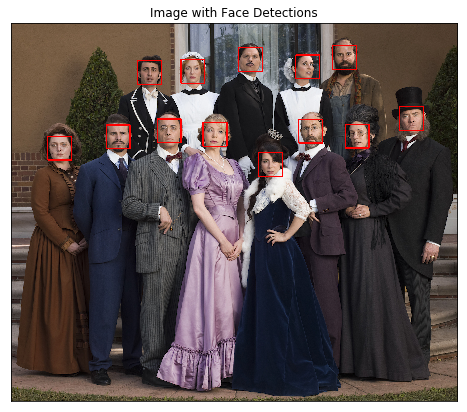

In [3]:
# Convert the RGB  image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Extract the pre-trained face detector from an xml file
face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')

# Detect the faces in image
faces = face_cascade.detectMultiScale(gray, 4, 6)

# Print the number of faces detected in the image
print('Number of faces detected:', len(faces))

# Make a copy of the orginal image to draw face detections on
image_with_detections = np.copy(image)

# Get the bounding box for each detected face
for (x,y,w,h) in faces:
    # Add a red bounding box to the detections image
    cv2.rectangle(image_with_detections, (x,y), (x+w,y+h), (255,0,0), 3)
    

# Display the image with the detections
fig = plt.figure(figsize = (8,8))
ax1 = fig.add_subplot(111)
ax1.set_xticks([])
ax1.set_yticks([])

ax1.set_title('Image with Face Detections')
ax1.imshow(image_with_detections)

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

---
<a id='step1'></a>

## Step 1: Add Eye Detections

There are other pre-trained detectors available that use a Haar Cascade Classifier - including full human body detectors, license plate detectors, and more.  [A full list of the pre-trained architectures can be found here](https://github.com/opencv/opencv/tree/master/data/haarcascades). 

To test the eye detector, we'll first read in a new test image with just a single face.

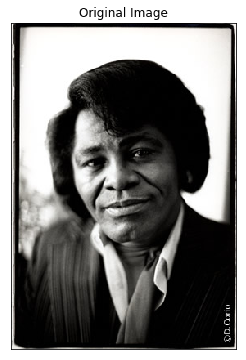

In [4]:
# Load in color image for face detection
image = cv2.imread('images/james.jpg')

# Convert the image to RGB colorspace
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Plot the RGB image
fig = plt.figure(figsize = (6,6))
ax1 = fig.add_subplot(111)
ax1.set_xticks([])
ax1.set_yticks([])

ax1.set_title('Original Image')
ax1.imshow(image)

Notice that even though the image is a black and white image, we have read it in as a color image and so it will still need to be converted to grayscale in order to perform the most accurate face detection.

So, the next steps will be to convert this image to grayscale, then load OpenCV's face detector and run it with parameters that detect this face accurately.

Number of faces detected: 1


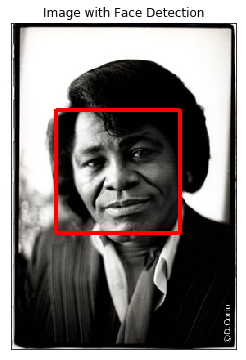

In [5]:
# Convert the RGB  image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Extract the pre-trained face detector from an xml file
face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')

# Detect the faces in image
faces = face_cascade.detectMultiScale(gray, 1.25, 6)

# Print the number of faces detected in the image
print('Number of faces detected:', len(faces))

# Make a copy of the orginal image to draw face detections on
image_with_detections = np.copy(image)

# Get the bounding box for each detected face
for (x,y,w,h) in faces:
    # Add a red bounding box to the detections image
    cv2.rectangle(image_with_detections, (x,y), (x+w,y+h), (255,0,0), 3)
    

# Display the image with the detections
fig = plt.figure(figsize = (6,6))
ax1 = fig.add_subplot(111)
ax1.set_xticks([])
ax1.set_yticks([])

ax1.set_title('Image with Face Detection')
ax1.imshow(image_with_detections)

### Addingn an eye detector to the current face detection setup.  

A Haar-cascade eye detector can be included in the same way that the face detector was.

To set up an eye detector, we use the stored parameters of the eye cascade detector, called ```haarcascade_eye.xml```, located in the `detector_architectures` subdirectory.

Second, since we've already run the face detector over this image, we will only search for eyes *within the rectangular face regions detected in ``faces``*.  This will minimize false detections.

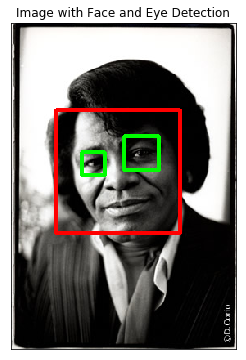

In [6]:
# Make a copy of the original image to plot rectangle detections
image_with_detections = np.copy(image)   

# Loop over the detections and draw their corresponding face detection boxes
for (x,y,w,h) in faces:
    cv2.rectangle(image_with_detections, (x,y), (x+w,y+h),(255,0,0), 3)  

eye_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_eye.xml')

eyes = eye_cascade.detectMultiScale(gray)
for (x, y, w, h) in eyes:
    cv2.rectangle(image_with_detections, (x, y), (x + w, y + h), (0, 255, 0), 3)

# Plot the image with both faces and eyes detected
fig = plt.figure(figsize = (6,6))
ax1 = fig.add_subplot(111)
ax1.set_xticks([])
ax1.set_yticks([])

ax1.set_title('Image with Face and Eye Detection')
ax1.imshow(image_with_detections)

---
<a id='step2'></a>

## Step 2: De-noise an Image for Better Face Detection

When applying a trained computer vision algorithm to a new piece of test data one often cleans it up first before feeding it in.  This sort of cleaning - referred to as *pre-processing* - can include a number of cleaning phases like blurring, de-noising, color transformations, etc., and many of these tasks can be accomplished using OpenCV.

In this short subsection we explore OpenCV's noise-removal functionality to see how we can clean up a noisy image, which we then feed into our trained face detector.

### Create a noisy image to work with

In the next cell, we create an artificial noisy version of the previous multi-face image.  This is a little exaggerated - we don't typically get images that are this noisy - but [image noise](https://digital-photography-school.com/how-to-avoid-and-reduce-noise-in-your-images/), or 'grainy-ness' in a digitial image - is a fairly common phenomenon.

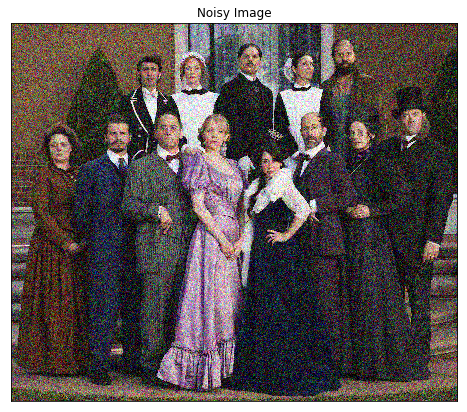

In [7]:
# Load in the multi-face test image again
image = cv2.imread('images/test_image_1.jpg')

# Convert the image copy to RGB colorspace
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Make an array copy of this image
image_with_noise = np.asarray(image)

# Create noise - here we add noise sampled randomly from a Gaussian distribution: a common model for noise
noise_level = 40
noise = np.random.randn(image.shape[0],image.shape[1],image.shape[2])*noise_level

# Add this noise to the array image copy
image_with_noise = image_with_noise + noise

# Convert back to uint8 format
image_with_noise = np.asarray([np.uint8(np.clip(i,0,255)) for i in image_with_noise])

# Plot our noisy image!
fig = plt.figure(figsize = (8,8))
ax1 = fig.add_subplot(111)
ax1.set_xticks([])
ax1.set_yticks([])

ax1.set_title('Noisy Image')
ax1.imshow(image_with_noise)

In the context of face detection, the problem with an image like this is that  - due to noise - we may miss some faces or get false detections.  

In the next cell we apply the same trained OpenCV detector with the same settings as before, to see what sort of detections we get.

Number of faces detected: 12


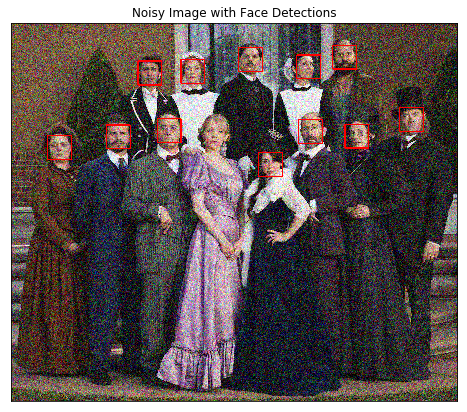

In [8]:
# Convert the RGB  image to grayscale
gray_noise = cv2.cvtColor(image_with_noise, cv2.COLOR_RGB2GRAY)

# Extract the pre-trained face detector from an xml file
face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')

# Detect the faces in image
faces = face_cascade.detectMultiScale(gray_noise, 4, 6)

# Print the number of faces detected in the image
print('Number of faces detected:', len(faces))

# Make a copy of the orginal image to draw face detections on
image_with_detections = np.copy(image_with_noise)

# Get the bounding box for each detected face
for (x,y,w,h) in faces:
    # Add a red bounding box to the detections image
    cv2.rectangle(image_with_detections, (x,y), (x+w,y+h), (255,0,0), 3)
    

# Display the image with the detections
fig = plt.figure(figsize = (8,8))
ax1 = fig.add_subplot(111)
ax1.set_xticks([])
ax1.set_yticks([])

ax1.set_title('Noisy Image with Face Detections')
ax1.imshow(image_with_detections)

With this added noise we now miss one of the faces.

### De-noise this image for better face detection

Using OpenCV's built in color image de-noising functionality called ```fastNlMeansDenoisingColored``` - we de-noise this image enough so that all the faces in the image are properly detected.  Once we have cleaned the image in the next cell, we can use the cell that follows to run our trained face detector over the cleaned image to check out its detections.

You can find its [official documentation here]([documentation for denoising](http://docs.opencv.org/trunk/d1/d79/group__photo__denoise.html#ga21abc1c8b0e15f78cd3eff672cb6c476) and [a useful example here](http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_photo/py_non_local_means/py_non_local_means.html).

In [30]:
denoised_image = cv2.fastNlMeansDenoisingColored(image_with_noise, None, 30, 100, 21, 7)

No. of faces detected :  13


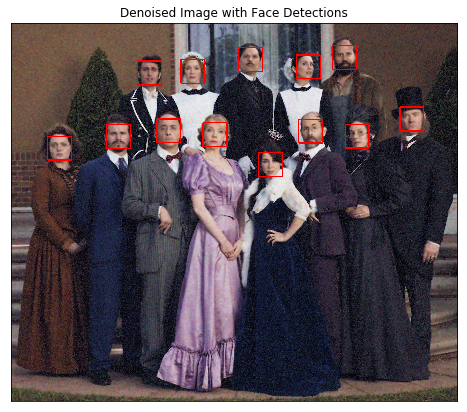

In [31]:
gray_denoised = cv2.cvtColor(denoised_image, cv2.COLOR_RGB2GRAY)

face_cascades = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')
faces = face_cascade.detectMultiScale(gray_denoised, 4, 6)

denoised_image_copy = np.copy(denoised_image)

print("No. of faces detected : ", len(faces))
for (x, y, w, h) in faces:
    cv2.rectangle(denoised_image_copy, (x, y), (x + w, y + h), (255, 0, 0), 3)

fig = plt.figure(figsize = (8,8))
ax1 = fig.add_subplot(111)
ax1.set_xticks([])
ax1.set_yticks([])

ax1.set_title('Denoised Image with Face Detections')
ax1.imshow(denoised_image_copy)

---
<a id='step3'></a>

## Step 3: Blur an Image and Perform Edge Detection

Now that we have developed a simple pipeline for detecting faces using OpenCV - let's start playing around with a few fun things we can do with all those detected faces!

### Importance of Blur in Edge Detection

Edge detection is a concept that pops up almost everywhere in computer vision applications, as edge-based features (as well as features built on top of edges) are often some of the best features for e.g., object detection and recognition problems.

Edge detection is a dimension reduction technique - by keeping only the edges of an image we get to throw away a lot of non-discriminating information.  And typically the most useful kind of edge-detection is one that preserves only the important, global structures (ignoring local structures that aren't very discriminative).  So removing local structures / retaining global structures is a crucial pre-processing step to performing edge detection in an image, and blurring can do just that.  

Below is an animated gif showing the result of an edge-detected cat [taken from Wikipedia](https://en.wikipedia.org/wiki/Gaussian_blur#Common_uses), where the image is gradually blurred more and more prior to edge detection.  When the animation begins you can't quite make out what it's a picture of, but as the animation evolves and local structures are removed via blurring the cat becomes visible in the edge-detected image.

<img src="images/Edge_Image.gif" width=400 height=300/>

Edge detection is a **convolution** performed on the image itself, and you can read about Canny edge detection on [this OpenCV documentation page](http://docs.opencv.org/2.4/doc/tutorials/imgproc/imgtrans/canny_detector/canny_detector.html).

### Canny edge detection

In the cell below we load in a test image, then apply *Canny edge detection* on it.  The original image is shown on the left panel of the figure, while the edge-detected version of the image is shown on the right.  Notice how the result looks very busy - there are too many little details preserved in the image before it is sent to the edge detector.  When applied in computer vision applications, edge detection should preserve *global* structure; doing away with local structures that don't help describe what objects are in the image.

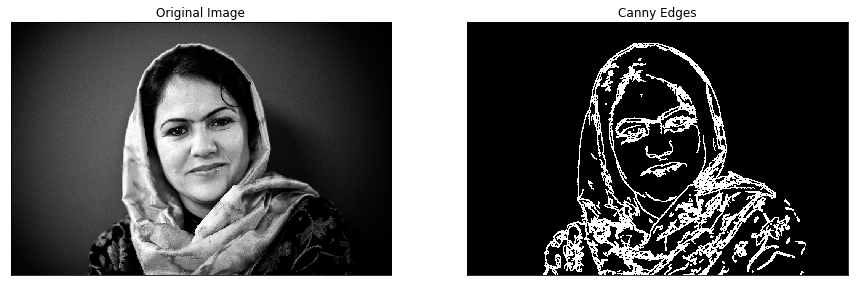

In [11]:
# Load in the image
image = cv2.imread('images/fawzia.jpg')

# Convert to RGB colorspace
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)  

# Perform Canny edge detection
edges = cv2.Canny(gray,100,200)

# Dilate the image to amplify edges
edges = cv2.dilate(edges, None)

# Plot the RGB and edge-detected image
fig = plt.figure(figsize = (15,15))
ax1 = fig.add_subplot(121)
ax1.set_xticks([])
ax1.set_yticks([])

ax1.set_title('Original Image')
ax1.imshow(image)

ax2 = fig.add_subplot(122)
ax2.set_xticks([])
ax2.set_yticks([])

ax2.set_title('Canny Edges')
ax2.imshow(edges, cmap='gray')

Without first blurring the image, and removing small, local structures, a lot of irrelevant edge content gets picked up and amplified by the detector (as shown in the right panel above). 

### Blur the image *then* perform edge detection

In the next cell, I will repeat this experiment - blurring the image first to remove these local structures, so that only the important boundary details remain in the edge-detected image.

We can blur the image by using OpenCV's ```filter2d``` functionality - which is discussed in [this documentation page](http://docs.opencv.org/3.1.0/d4/d13/tutorial_py_filtering.html) - and use an *averaging kernel* of width equal to 4.

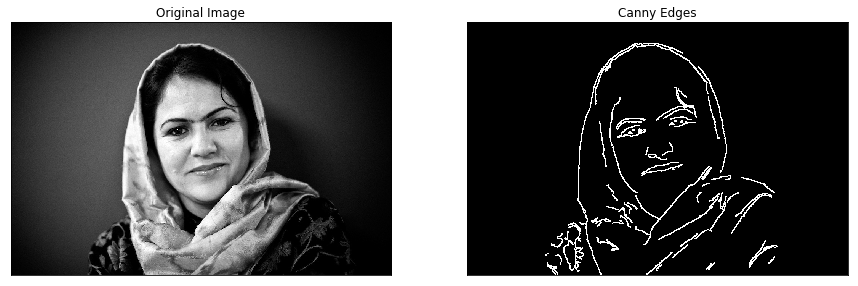

In [12]:
# Using an averaging kernel with width equal to 4
kernel = np.array([[1, 1, 1, 1],
                  [1, 1, 1, 1],
                  [1, 1, 1, 1]]) * (1 / 16)
filtered_image = cv2.filter2D(gray, -1, kernel)

edges = cv2.Canny(filtered_image, 100, 200)
edges = cv2.dilate(edges, None)

fig = plt.figure(figsize = (15,15))
ax1 = fig.add_subplot(121)
ax1.set_xticks([])
ax1.set_yticks([])

ax1.set_title('Original Image')
ax1.imshow(image)

ax2 = fig.add_subplot(122)
ax2.set_xticks([])
ax2.set_yticks([])

ax2.set_title('Canny Edges')
ax2.imshow(edges, cmap = 'gray')

---
<a id='step4'></a>

## Step 4: Automatically Hide the Identity of an Individual

If you film something like a documentary or reality TV, you must get permission from every individual shown on film before you can show their face, otherwise you need to blur it out - by blurring the face a lot (so much so that even the global structures are obscured)!  This is also true for projects like [Google's StreetView maps](https://www.google.com/streetview/) - an enormous collection of mapping images taken from a fleet of Google vehicles.  Because it would be impossible for Google to get the permission of every single person accidentally captured in one of these images they blur out everyone's faces, the detected images must automatically blur the identity of detected people.  Here's a few examples of folks caught in the camera of a Google street view vehicle.

<img src="images/streetview_example_1.jpg" width=400 height=300/>
<img src="images/streetview_example_2.jpg" width=400 height=300/>


### Read in an image to perform identity detection

We will use the face detection pipeline built above and ```filter2D``` to blur the image below.

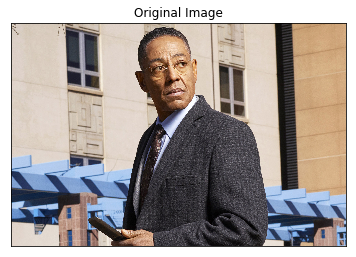

In [13]:
# Load in the image
image = cv2.imread('images/gus.jpg')

# Convert the image to RGB colorspace
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image
fig = plt.figure(figsize = (6,6))
ax1 = fig.add_subplot(111)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('Original Image')
ax1.imshow(image)

### Use blurring to hide the identity of an individual in an image

The idea here is to 1) automatically detect the face in this image, and then 2) blur it out!  We will adjust the parameters of the *averaging* blur filter to completely obscure this person's identity.

In [14]:
# denoising since more than one faces were being detected
denoised_image = cv2.fastNlMeansDenoisingColored(image, None, 10, 20, 7, 21)

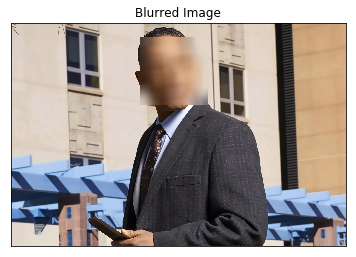

In [15]:
gray = cv2.cvtColor(denoised_image, cv2.COLOR_RGB2GRAY)
faces = face_cascades.detectMultiScale(gray)
image_copy = np.copy(denoised_image)

kernel = np.ones((100, 100)) / 10000

for (x, y, w, h) in faces:
    blur = cv2.filter2D(image_copy[y : y + h, x : x + w], -1, kernel)
    image_copy[y : y + h, x : x + w] = blur
fig = plt.figure(figsize = (6,6))
ax1 = fig.add_subplot(111)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('Blurred Image')
ax1.imshow(image_copy)

---
<a id='step5'></a>

## Step 5: Create a CNN to Recognize Facial Keypoints

OpenCV is often used in practice with other machine learning and deep learning libraries to produce interesting results.  In this stage of the project we will create our own end-to-end pipeline - employing convolutional networks in keras along with OpenCV - to apply a "selfie" filter to streaming video and images.  

We will start by creating and then training a convolutional network that can detect facial keypoints in a small dataset of cropped images of human faces.  We will then use OpenCV to expanding our detection algorithm to more general images.

<img src="images/keypoints_test_results.png" width=400 height=300/>

Facial keypoints (also called facial landmarks) are the small blue-green dots shown on each of the faces in the image above - there are 15 keypoints marked in each image.  They mark important areas of the face - the eyes, corners of the mouth, the nose, etc.  Facial keypoints can be used in a variety of machine learning applications from face and emotion recognition to commercial applications like the image filters popularized by Snapchat.

Below we illustrate a filter that, using the results of this section, automatically places sunglasses on people in images (using the facial keypoints to place the glasses correctly on each face).  Here, the facial keypoints have been colored lime green for visualization purposes.

<img src="images/obamas_with_shades.png" width=1000 height=1000/>

### Make a facial keypoint detector

How can we make a facial keypoint detector?  At a high level, notice that facial keypoint detection is a *regression problem*.  A single face corresponds to a set of 15 facial keypoints (a set of 15 corresponding $(x, y)$ coordinates, i.e., an output point).  Because our input data are images, we can employ a *convolutional neural network* to recognize patterns in our images and learn how to identify these keypoint given sets of labeled data.

In order to train a regressor, we need a training set - a set of facial image / facial keypoint pairs to train on.  For this we will be using [this dataset from Kaggle](https://www.kaggle.com/c/facial-keypoints-detection/data).  The training dataset contains several thousand $96 \times 96$ grayscale images of cropped human faces, along with each face's 15 corresponding facial keypoints (also called landmarks) that have been placed by hand, and recorded in $(x, y)$ coordinates.  This resource also has a substantial testing set, which we will use in tinkering with our convolutional network.

To load in this data, run the Python cell below.

The `load_data` function is in the included `utils.py` file.

In [16]:
from utils import *

# Load training set
X_train, y_train = load_data()
print("X_train.shape == {}".format(X_train.shape))
print("y_train.shape == {}; y_train.min == {:.3f}; y_train.max == {:.3f}".format(
    y_train.shape, y_train.min(), y_train.max()))

# Load testing set
X_test, _ = load_data(test=True)
print("X_test.shape == {}".format(X_test.shape))

Using TensorFlow backend.


X_train.shape == (2140, 96, 96, 1)
y_train.shape == (2140, 30); y_train.min == -0.920; y_train.max == 0.996
X_test.shape == (1783, 96, 96, 1)


The `load_data` function in `utils.py` originates from this excellent [blog post](http://danielnouri.org/notes/2014/12/17/using-convolutional-neural-nets-to-detect-facial-keypoints-tutorial/).  Note that the output values - the coordinates of each set of facial landmarks - have been normalized to take on values in the range $[-1, 1]$, while the pixel values of each input point (a facial image) have been normalized to the range $[0,1]$.  

Note: the original Kaggle dataset contains some images with several missing keypoints.  The `load_data` function removes those images with missing labels from the dataset.

### Visualize the Training Data

Execute the code cell below to visualize a subset of the training data.

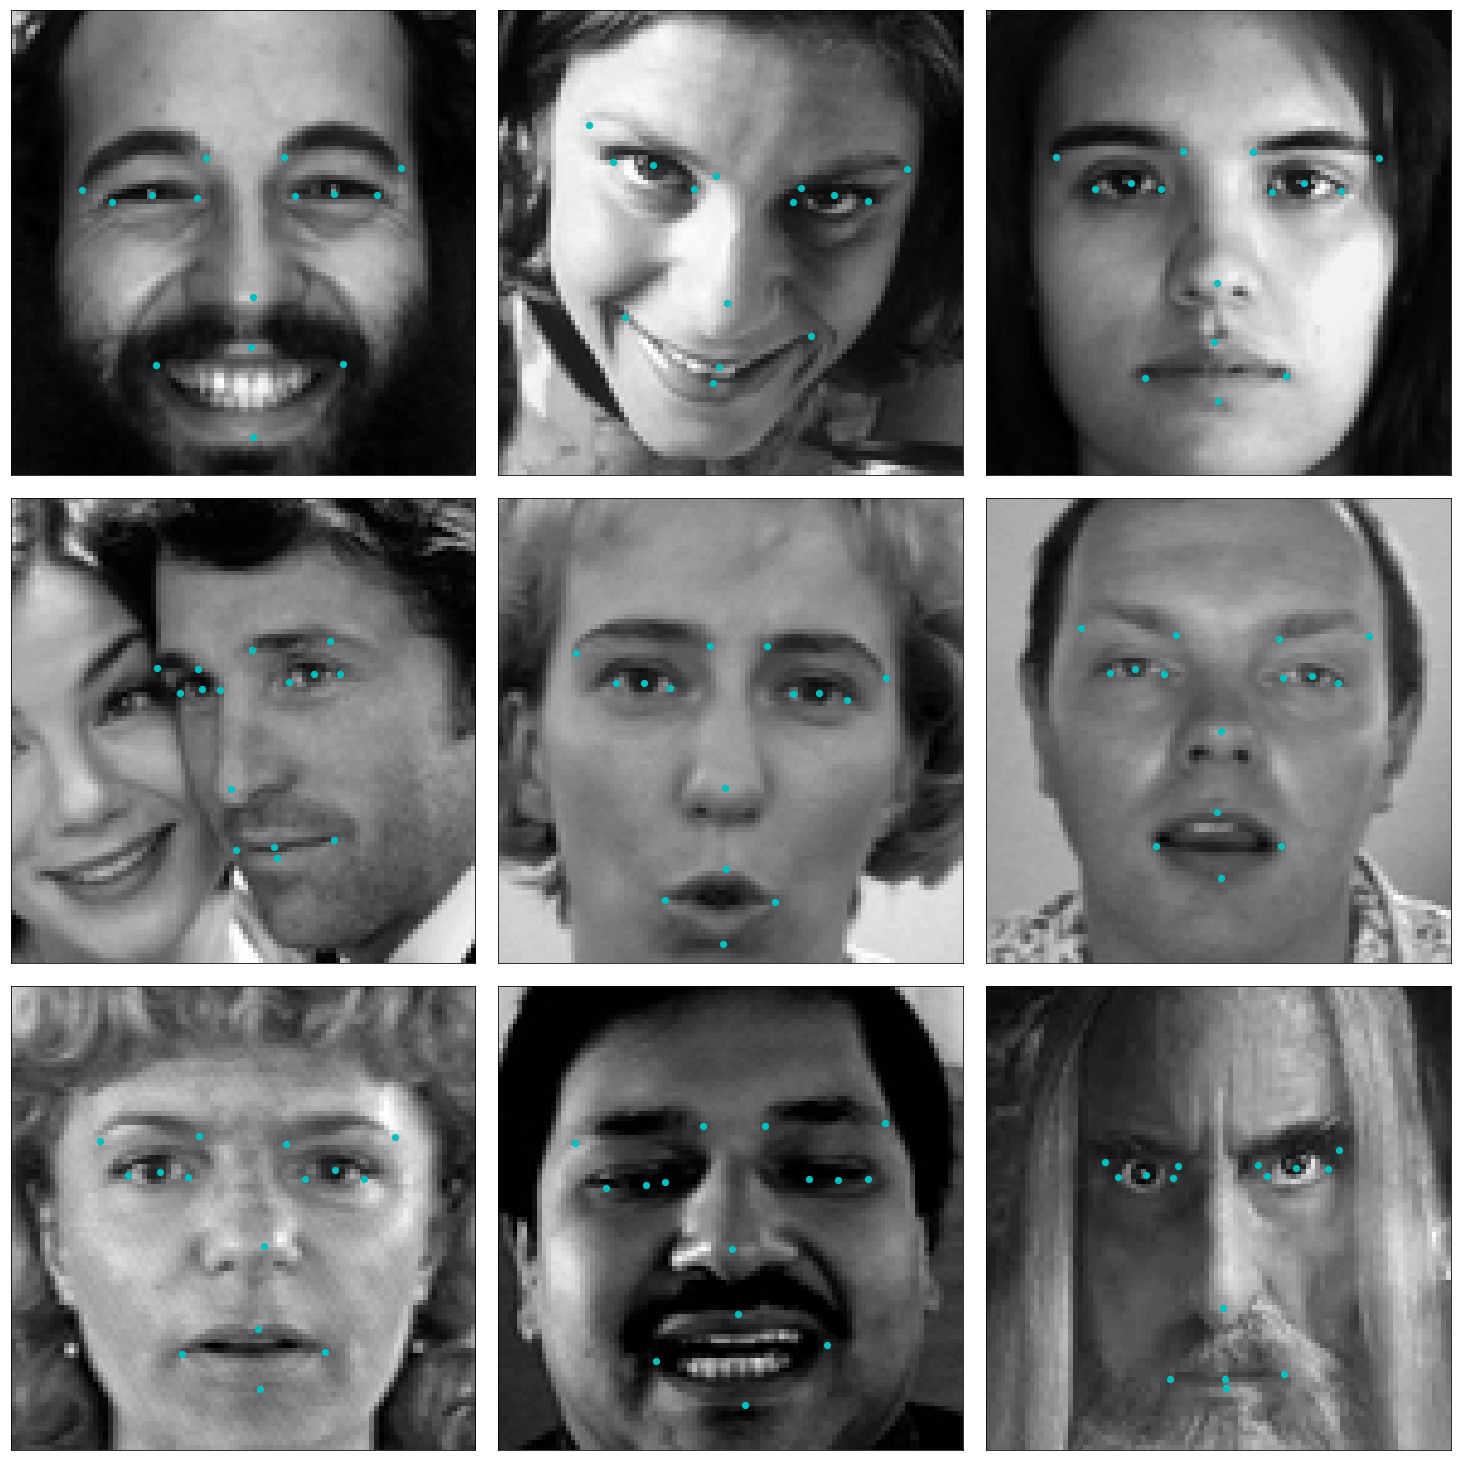

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
    plot_data(X_train[i], y_train[i], ax)

For each training image, there are two landmarks per eyebrow (**four** total), three per eye (**six** total), **four** for the mouth, and **one** for the tip of the nose.  

### Specify the CNN Architecture

In this section, we will specify a neural network for predicting the locations of facial keypoints.

In [18]:
# Import deep learning resources from Keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, GlobalMaxPooling2D
from keras.layers import Flatten, Dense

model = Sequential()

model.add(Conv2D(filters = 8, kernel_size = (3, 3), activation = 'relu', padding = 'same', input_shape = (96, 96, 1)))
model.add(MaxPooling2D(pool_size = 2, padding = 'same'))
model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(MaxPooling2D(pool_size = 2, padding = 'same'))
model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(MaxPooling2D(pool_size = 2, padding = 'same'))
model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(MaxPooling2D(pool_size = 2, padding = 'same'))
model.add(Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(GlobalMaxPooling2D())
model.add(Dense(500))
model.add(Dense(30))


# Summarize the model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 96, 8)         80        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 16)        1168      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 64)        18496     
__________

---
<a id='step6'></a>

## Step 6: Compile and Train the Model

After specifying our architecture, we'll need to compile and train the model to detect facial keypoints.

### Compile and Train the Model

In [19]:
from keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam
from keras.callbacks import ModelCheckpoint

model.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='weights.best.my_model.hdf5', 
                               verbose=0, save_best_only=True)

hist = model.fit(X_train, y_train, batch_size = 10, epochs = 50, validation_split = 0.2, callbacks = [checkpointer])

model.save('my_model.h5')

Train on 1712 samples, validate on 428 samples
Epoch 1/50
1712/1712 [==============================] - 2s - loss: 0.0088 - acc: 0.6799 - val_loss: 0.0049 - val_acc: 0.6963
Epoch 2/50
1712/1712 [==============================] - 1s - loss: 0.0044 - acc: 0.7068 - val_loss: 0.0040 - val_acc: 0.6963
Epoch 3/50
1712/1712 [==============================] - 1s - loss: 0.0040 - acc: 0.7050 - val_loss: 0.0038 - val_acc: 0.6963
Epoch 4/50
1712/1712 [==============================] - 1s - loss: 0.0037 - acc: 0.7120 - val_loss: 0.0033 - val_acc: 0.6963
Epoch 5/50
1712/1712 [==============================] - 1s - loss: 0.0029 - acc: 0.7167 - val_loss: 0.0027 - val_acc: 0.7290
Epoch 6/50
1712/1712 [==============================] - 1s - loss: 0.0023 - acc: 0.7284 - val_loss: 0.0022 - val_acc: 0.7243
Epoch 7/50
1712/1712 [==============================] - 1s - loss: 0.0019 - acc: 0.7278 - val_loss: 0.0021 - val_acc: 0.7313
Epoch 8/50
1712/1712 [==============================] - 1s - loss: 0.0017 - ac

---
<a id='step7'></a>

## Step 7: Visualize the Loss and Test Predictions

### Answering a few questions and visualizing the loss

__Question 1:__ Outline the steps you took to get to your final neural network architecture and your reasoning at each step.

__Answer:__ Initially, I started with the model which I created during the dog breed prediction project, only now since it was a regression problem so I removed the activation function from output layer and used mean_squared_error instead of categorical_cross_entropy, with batch_size = 10 and 100 epochs which converged at a val_loss of 0.005. Now, after reading the above mentioned post, I tried changing the kernel size of 2x2 to 3x3 in order to capture a wider range of pixels which will make differences between adjacent values more prominent if present at all. I also added another dense layer of 500 nodes (in a similar manner as described in the provided post) which I believe was in order to detect more number of interrelated connections between neighbouring values, which also explains why it was introduced at a later stage in the model as these patterns might not be visible until we go deeper. This bumped my val_loss to 0.003. After this I thought it would be better if I added one more convolution layer so that the model can extract higher level features for improved detection. At the end I decided to use a GlobalMaxPooling layer to reduce the dimensionality and extract only those values from each channel that "stood out" from their neighbours. By performing all of the above I was able to reach a validation loss of 0.0012.


__Question 2:__ Defend your choice of optimizer.  Which optimizers did you test, and how did you determine which worked best?

__Answer:__ I first chose RMSprop which consistently used to perform well in CNNs for classification problems, but since this was a regression problem I tried SGD. SGD proved to be very slow in converging so instead I tried Adam optimizer. Adam has been proved to be good for problems where the gradient is smaller and works well with large number of parameters, which was the case with my model. It also gave me significantly better results in a lesser amount of time while converging quickly as can be seen in the below graph. Thus, after testing RMSprop, SGD, and Adam optimizers I went with Adam as it was most efficient in convergence.

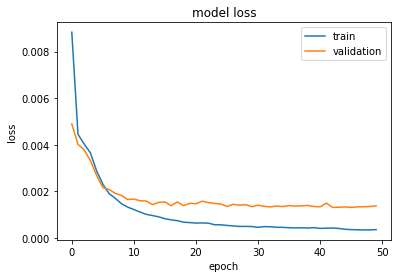

In [20]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

__Question 3:__  Do you notice any evidence of overfitting or underfitting in the above plot?

__Answer:__ As I explained above my model was underfitting earlier, so I added another convolution layer to extract more features and improve my model. I also added a GlobalMaxPooling layer in order to decrease dimensionality if overfitting occurred.

### Visualize a Subset of the Test Predictions

Executing the code cell below we will be able to visualize our model's predicted keypoints on a subset of the testing images.

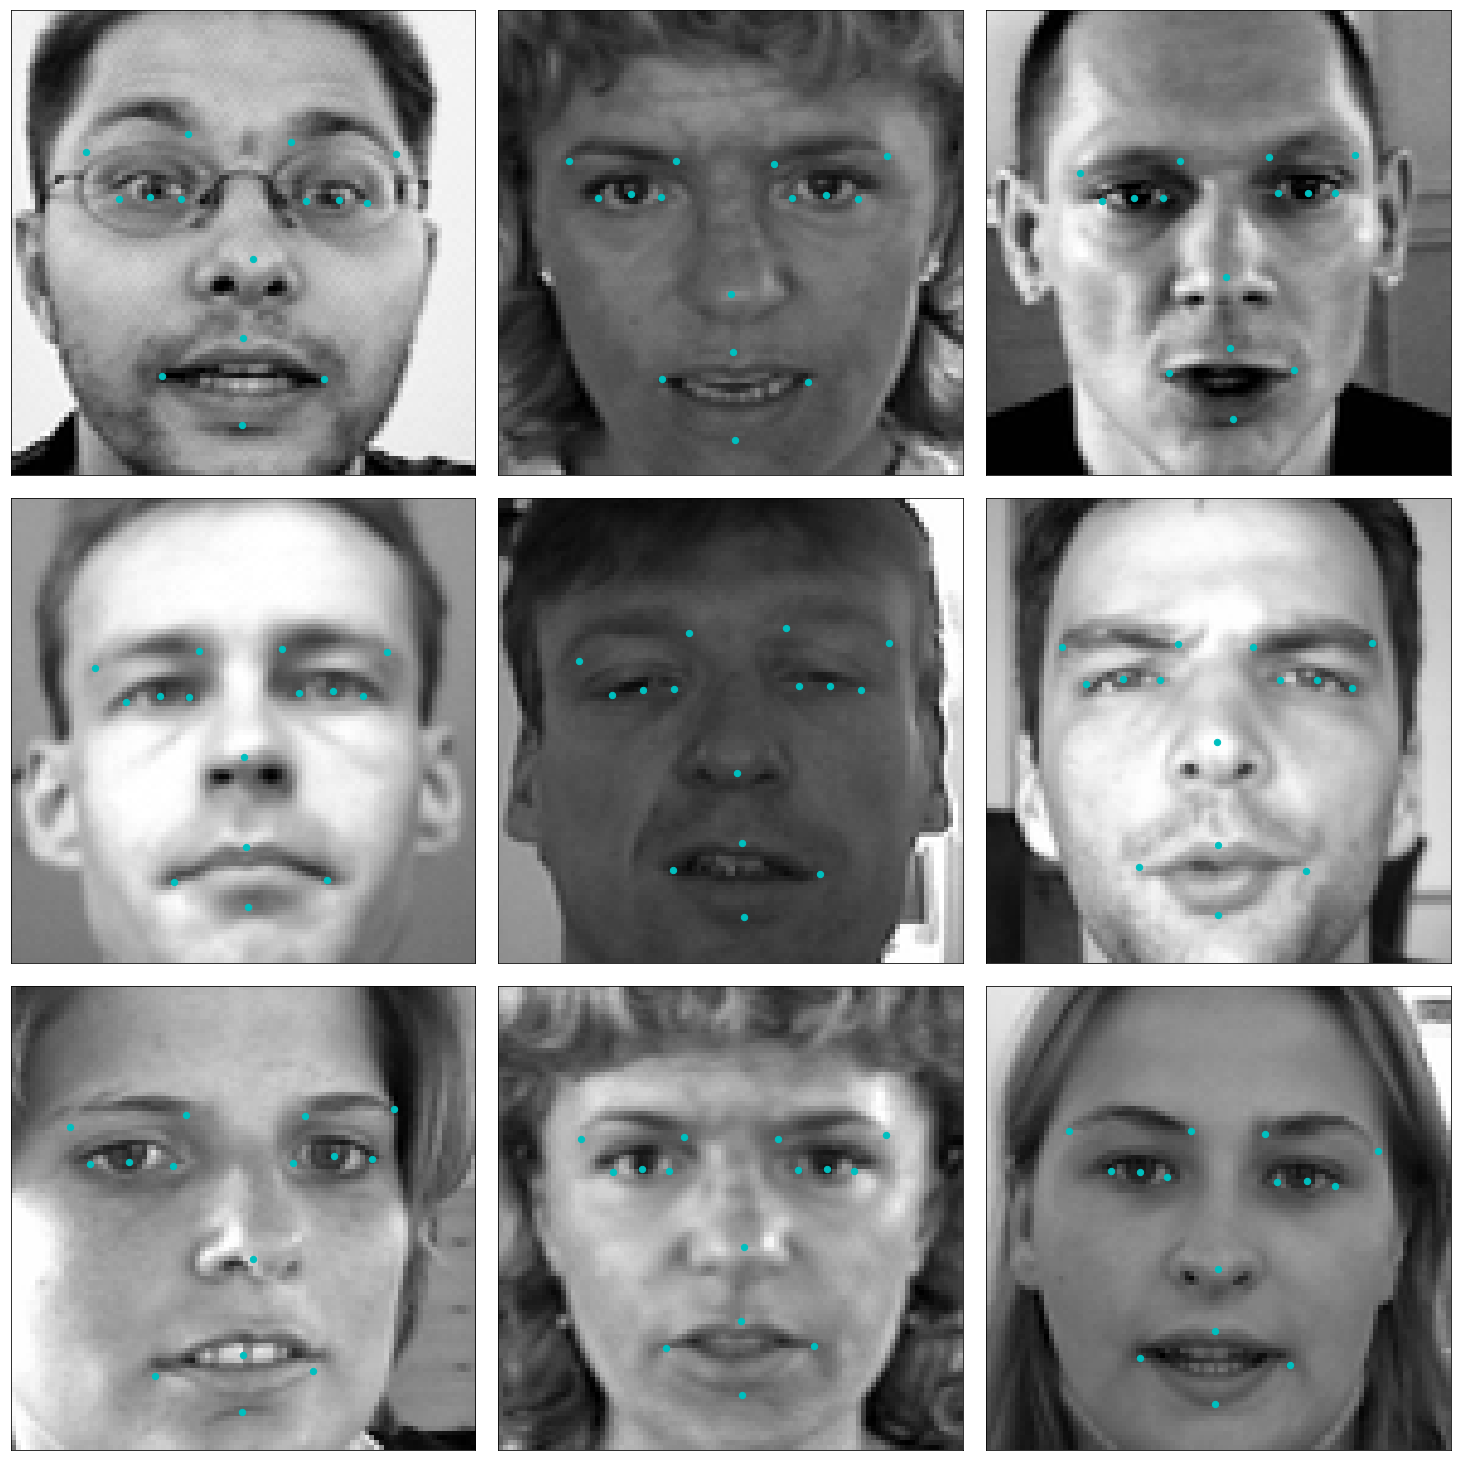

In [21]:
y_test = model.predict(X_test)
fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
    plot_data(X_test[i], y_test[i], ax)

---
<a id='step8'></a>

## Step 8: Complete the pipeline

With the work we did in Sections 1 and 2 of this notebook, along with our freshly trained facial keypoint detector, we can now complete the full pipeline.  That is given a color image containing a person or persons we can now 

- Detect the faces in this image automatically using OpenCV
- Predict the facial keypoints in each face detected in the image
- Paint predicted keypoints on each face detected

### Facial Keypoints Detector

Our function should perform the following steps

1. Accept a color image.
2. Convert the image to grayscale.
3. Detect and crop the face contained in the image.
4. Locate the facial keypoints in the cropped image.
5. Overlay the facial keypoints in the original (color, uncropped) image.

When complete we will be able to produce example images like the one below.

<img src="images/obamas_with_keypoints.png" width=1000 height=1000/>

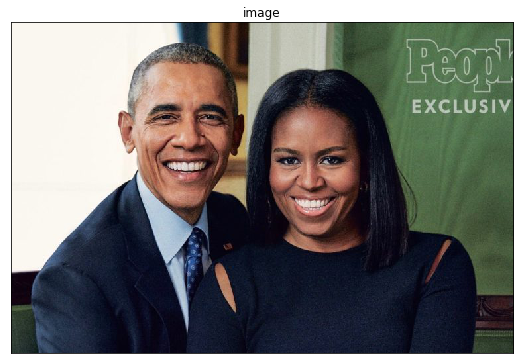

In [22]:
# Load in color image for face detection
image = cv2.imread('images/obamas4.jpg')


# Convert the image to RGB colorspace
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# plot our image
fig = plt.figure(figsize = (9,9))
ax1 = fig.add_subplot(111)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('image')
ax1.imshow(image)

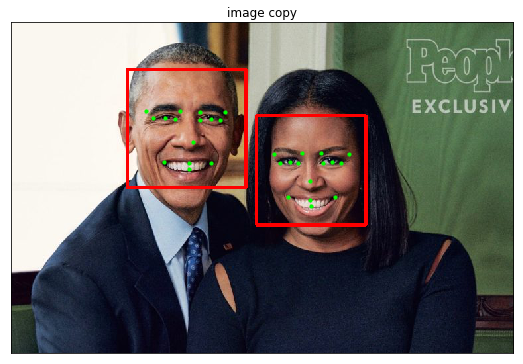

In [43]:
from keras.models import load_model

gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
image_copy = np.copy(image)

face_cascades = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')
faces = face_cascades.detectMultiScale(gray)

all_keypoints = []
for (x, y, w, h) in faces:
    cv2.rectangle(image_copy, (x, y), (x + w, y + h), (255, 0, 0), 3)

    face_only = image_copy[y : y + h, x : x + w]
    orig_face_only_shape = face_only.shape
    
    gray_crop = cv2.cvtColor(face_only, cv2.COLOR_RGB2GRAY)
    resize_gray_crop = cv2.resize(gray_crop, (96, 96)) / 255.
    
    model = load_model('my_model.h5')
    
    landmarks = np.squeeze(model.predict(np.expand_dims(np.expand_dims(resize_gray_crop, axis=-1), axis=0)))
    
    all_keypoints.append((((landmarks[0 : : 2] * 48 + 48) * orig_face_only_shape[0] / 96) + x,
                        ((landmarks[1 : : 2] * 48 + 48) * orig_face_only_shape[1] / 96) + y))
    
fig = plt.figure(figsize = (9,9))
ax1 = fig.add_subplot(111)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('image copy')
for (x, y) in all_keypoints:
    ax1.scatter(x, y, marker = 'o', c = [[0, 1, 0]], s = 10)
ax1.imshow(image_copy)